In [1]:
# imports
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob
import math
%matplotlib inline

In [2]:
def undistort_single(img):
    undistorted = cv2.undistort(img, mtx, dist, None, mtx)
    return undistorted

def undistort(testImages, plot=False, save=False):
    result = []
    for fName in testImages:
        img = mpimg.imread(fName)
        undistorted = undistort_single(img)
        result.append(undistorted)
        fNameShort = fName.split('/')[2]
        if plot:            
            f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
            f.tight_layout()
            ax1.imshow(img)
            ax1.set_title('Original ' + fNameShort, fontsize=40)
            ax2.imshow(undistorted)
            ax2.set_title('Undistorted ' + fNameShort, fontsize=40)
            plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
        if save:           
            [fn, extension] = fNameShort.split('.')
            outputPath = 'output_images/' + fn + '_undistorted.png'
            mpimg.imsave(outputPath, img)
    return result

In [3]:
# camera calibration
images = glob.glob('./camera_cal/calibration*.jpg')

nX = 9
nY = 6

objpoints = []
imgpoints = []
validationImages = [] # use images that did not contain expected chessboard grid as validation images

objp = np.zeros((nY*nX,3),np.float32)
objp[:,:2] = np.mgrid[0:nX,0:nY].T.reshape(-1,2)

for fName in images:
    
    img = mpimg.imread(fName)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    ret, corners = cv2.findChessboardCorners(gray, (nX,nY), None)

    if ret:
        imgpoints.append(corners)
        objpoints.append(objp)
        ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
    else:
        validationImages.append(fName)

# test result on images not used for calibration
undistort(validationImages);

In [4]:
# distortion correction on raw images

# read in test_images
testImages = glob.glob('./test_images/*.jpg')

# undistort and save to output folder
undistort(testImages, save=True);


In [5]:
# perspective transformation - helper function

import matplotlib.lines as mlines

def transform_perspective(img, plot=False):
    
    yHighSrc = 456
    yLowSrc = 678
    x1Src = 275
    x2Src = 587
    x3Src = 699
    x4Src = 1046
    
    if plot:
        f, ax = plt.subplots(figsize=(24, 9))
        f.tight_layout()
        ax.imshow(img)
        plt.plot(x2Src, yHighSrc, '.') # upper left
        plt.plot(x3Src, yHighSrc, '.') # upper right
        plt.plot(x4Src, yLowSrc, '.') # lower right
        plt.plot(x1Src, yLowSrc, '.') # lower left
        l1 = mlines.Line2D([x1Src,x2Src], [yLowSrc,yHighSrc])
        l2 = mlines.Line2D([x3Src,x4Src], [yHighSrc,yLowSrc])
        ax.add_line(l1)
        ax.add_line(l2)
        plt.show()

    src = np.float32([[x2Src,yHighSrc],[x3Src,yHighSrc],[x4Src,yLowSrc],[x1Src,yLowSrc]])

    yHighDst = 0
    yLowDst = img.shape[0]
    xLowDst = np.int32((x1Src + x2Src)/2)
    xHighDst = np.int32((x3Src + x4Src)/2)
    
    dst = np.float32([[xLowDst,yHighDst],[xHighDst,yHighDst],[xHighDst,yLowDst],[xLowDst,yLowDst]])

    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    
    img_size = (img.shape[1], img.shape[0])
    warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)
        
    return warped, M, Minv


In [6]:
def invert_perspective_transform(img, Minv, img_size):
    unwarped = cv2.warpPerspective(img, Minv, img_size, flags=(cv2.INTER_LINEAR))    
    return unwarped

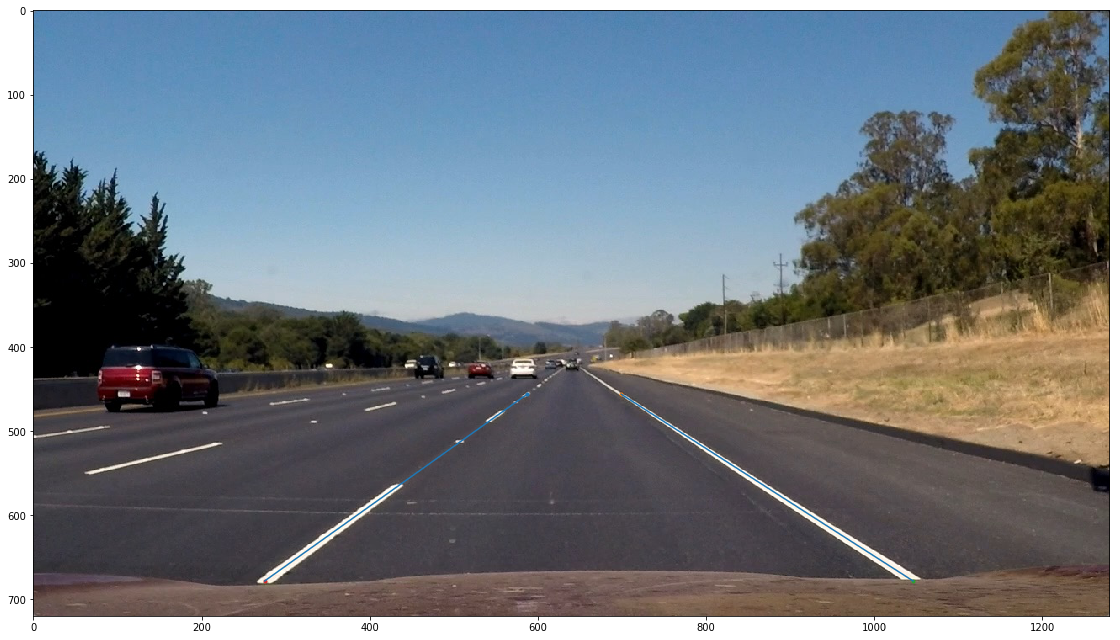

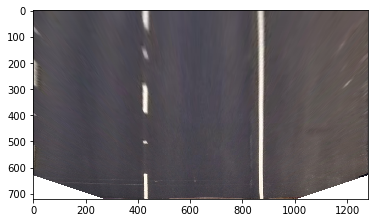

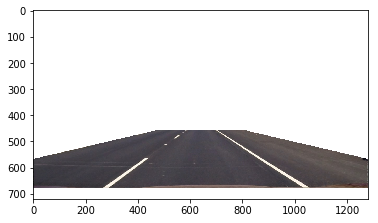

In [7]:
# test perspective transformation and inversion

img = mpimg.imread('./output_images/straight_lines2_undistorted.png')
[imagePerspectiveTransformed, M, Minv] = transform_perspective(img, plot=True)
plt.imshow(imagePerspectiveTransformed)
plt.show()

img_size = (img.shape[1], img.shape[0])
unwarped = invert_perspective_transform(imagePerspectiveTransformed, Minv, img_size)
plt.imshow(unwarped)
plt.show()

In [8]:
# perspective transform test images

# read in undistorted test images
testImages = glob.glob('./output_images/*_undistorted.png')

# transform perspective and save to ouput folder
for fName in testImages:
    img = mpimg.imread(fName)
    [imagePerspectiveTransformed, M, Minv] = transform_perspective(img)
    outputPath = fName.replace('_undistorted', '_perspective_transformed')
    mpimg.imsave(outputPath, imagePerspectiveTransformed)

In [9]:
def colorGradient(image):
    
    r_channel = image[:,:,0]
    
    # Define thresholds
    s_thresh=(170, 255)
    r_thresh=(120, 255)
    sx_thresh=(30, 100)

    # Convert to HLS color space
    img = np.copy(image)
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]

    # Take the derivative in x 
    sobelx = cv2.Sobel(l_channel, cv2.CV_64F, 1, 0) 
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
       
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold s channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Threshold r channel
    r_binary = np.zeros_like(r_channel)
    r_binary[(r_channel >= r_thresh[0]) & (r_channel <= r_thresh[1])] = 1   
    
    # return combined channels
    return r_binary & (sxbinary | s_binary)
   
def gaussian_blur(img):
    kernel_size = 5
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

In [326]:
class Line():
    n = 5
    threshold_fit = np.array([0.01, 1, 70], dtype='float')
    ym_per_pix = 30/720 # meters per pixel in y dimension
    xm_per_pix = 3.7/700 # meters per pixel in x dimension
    
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False
        # x values of the last n fits of the line
        self.recent_xfitted = []
        # polynomial coefficients of the last n iterations
        self.recent_fits = []
        # polynomial coefficients averaged over the last n iterations
        self.best_fit = None
        # polynomial coefficients for the most recent fit
        self.current_fit = [np.array([False])]
        # radius of curvature of the line in some units
        self.radius_of_curvature = None
        self.recent_radius = []
        self.averaged_radius = None
        # distance in meters of vehicle center from the line
        self.line_base_pos = None 
        # difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float')
        # x values for detected line pixels
        self.allx = None
        # y values for detected line pixels
        self.ally = None
        
    def update_curvature_real(self):
        y = self.ally*self.ym_per_pix
        fit_cr = np.polyfit(y, self.allx*self.xm_per_pix, 2)
        
        # measuring the radius of curvature at the bottom of the image
        y_eval = np.max(y)

        # calculation of R_curve (radius of curvature)
        a = fit_cr[0]
        b = fit_cr[1]
        self.radius_of_curvature = ((1+(2*a*y_eval+b)**2)**(3/2))/np.absolute(2*a)
    
        # append to list
        self.recent_radius.append(self.radius_of_curvature)
        if(len(self.recent_radius) > self.n):
            self.recent_radius.pop(0)
            
        # calculate average
        self.averaged_radius = np.average(self.recent_radius, weights=range(1,len(self.recent_radius)+1))
        
    def update_line_base_pos(self, x_base):
        self.line_base_pos = x_base*self.xm_per_pix
        
    def update_recent_xfitted(self, xfit):
        self.recent_xfitted.append(xfit)
        if(len(self.recent_xfitted) > self.n):
            self.recent_xfitted.pop(0)
            
    def update_recent_fits(self, fit):
        self.recent_fits.append(fit)
        if(len(self.recent_fits) > self.n):
            self.recent_fits.pop(0)
            
    def updateProperties(self, xfit, yfit, fit, diffs):
        self.update_recent_xfitted(xfit)
        self.update_recent_fits(fit)
        self.best_fit = np.average(self.recent_fits, axis=0, weights=range(1,len(self.recent_fits)+1))
        self.current_fit = fit
        self.diffs = diffs
        self.allx = xfit
        self.ally = yfit
        self.update_curvature_real()
    
    def determine_detected(self, diffs):
        self.detected = (np.absolute(diffs[0]) <= self.threshold_fit[0]) and \
            (np.absolute(diffs[1]) <= self.threshold_fit[1]) and \
            (np.absolute(diffs[2]) <= self.threshold_fit[2])

In [327]:
def find_midpoint_and_bases(binary_warped):
    # histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)

    midpoint = np.int(histogram.shape[0]//2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    return midpoint, leftx_base, rightx_base

def handle_detection_result(leftx, lefty, rightx, righty):
    
    global leftLine, rightLine
    
    # Fit a second order polynomial to each
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)

    leftDiffs = np.array([0,0,0], dtype='float') 
    rightDiffs = np.array([0,0,0], dtype='float') 
    
    # determine difference in fit coefficients between last and new fits
    if leftLine.current_fit[0]:
        leftDiffs = left_fit - leftLine.current_fit
        rightDiffs = right_fit - rightLine.current_fit
   
    leftLine.determine_detected(leftDiffs)
    rightLine.determine_detected(rightDiffs)
    
    if (leftLine.detected and rightLine.detected):
        leftLine.updateProperties(leftx, lefty, left_fit, leftDiffs)
        rightLine.updateProperties(rightx, righty, right_fit, rightDiffs)


def find_lane_pixels(binary_warped):
    [midpoint, leftx_base, rightx_base] = find_midpoint_and_bases(binary_warped)

    nwindows = 9 # number of sliding windows
    margin = 100 # set the width of the windows +/- margin
    minpix = 50 # minimum number of pixels found to recenter window

    window_height = np.int(binary_warped.shape[0]//nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated later for each window in nwindows
    leftx_current = leftx_base
    rightx_current = rightx_base

    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []

    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
               
        # Identify the nonzero pixels in x and y within the window ###
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & 
        (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzerox >= win_xright_low) & (nonzerox < win_xright_high) & 
        (nonzeroy >= win_y_low) & (nonzeroy < win_y_high)).nonzero()[0]

        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        
        ### If you found > minpix pixels, recenter next window ###
        ### (`right` or `leftx_current`) on their mean position ###
        if (good_left_inds.size > minpix):
            leftx_current = np.mean(nonzerox[good_left_inds], dtype=np.int)
        if (good_right_inds.size > minpix):
            rightx_current = np.mean(nonzerox[good_right_inds], dtype=np.int)

    # Concatenate the arrays of indices (previously was a list of lists of pixels)
    try:
        left_lane_inds = np.concatenate(left_lane_inds)
        right_lane_inds = np.concatenate(right_lane_inds)
    except ValueError:
        # Avoids an error if the above is not implemented fully
        pass

    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    handle_detection_result(leftx, lefty, rightx, righty)

def search_around_poly(binary_warped):
    margin = 100

    # Grab activated pixels
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    
    global leftLine, rightLine
    left_fit = leftLine.current_fit
    right_fit = rightLine.current_fit
    
    nonzerox_poly_left = left_fit[0]*nonzeroy**2+left_fit[1]*nonzeroy+left_fit[2]
    nonzerox_poly_right = right_fit[0]*nonzeroy**2+right_fit[1]*nonzeroy+right_fit[2]
    left_lane_inds = ((nonzerox >= nonzerox_poly_left-margin) & (nonzerox < nonzerox_poly_left+margin)).nonzero()[0]
    right_lane_inds = ((nonzerox >= nonzerox_poly_right-margin) & (nonzerox < nonzerox_poly_right+margin)).nonzero()[0]
    
    # Again, extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds] 
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]  
    
    handle_detection_result(leftx, lefty, rightx, righty)
    
def fit_polynomial(binary_warped):
    global leftLine, rightLine
    
    if (leftLine.detected and rightLine.detected):        
        search_around_poly(binary_warped)
    # value can change during above step, that's why I don't use 'else' here
    if (not(leftLine.detected and rightLine.detected)):
        find_lane_pixels(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
    try:
        left_fitx = leftLine.best_fit[0]*ploty**2 + leftLine.best_fit[1]*ploty + leftLine.best_fit[2]
        right_fitx = rightLine.best_fit[0]*ploty**2 + rightLine.best_fit[1]*ploty + rightLine.best_fit[2]
    except TypeError:
        # Avoids an error if `left` and `right_fit` are still none or incorrect
        print('The function failed to fit a line!')
        left_fitx = 1*ploty**2 + 1*ploty
        right_fitx = 1*ploty**2 + 1*ploty

    ## Visualization ##
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(binary_warped).astype(np.uint8)
    laneArea = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(laneArea, np.int_([pts]), (0,255, 0))

    # Colors in the left and right lane regions
    coloredLanes = np.dstack((binary_warped, binary_warped, binary_warped))
    coloredLanes[leftLine.ally, leftLine.allx] = [255, 0, 0]
    coloredLanes[rightLine.ally, rightLine.allx] = [0, 0, 255]
    
    lanes = cv2.addWeighted(laneArea, 0.3, coloredLanes, 1, 0)
    
#     # Plots the left and right polynomials on the lane lines
# #     fig = plt.figure()
# #     plt.plot(left_fitx, ploty, color='yellow')
# #     plt.plot(right_fitx, ploty, color='yellow')

    return lanes
    

In [328]:
def average_curvature_text():
    average_curverad = (leftLine.averaged_radius + rightLine.averaged_radius)/2 
    radiusText = 'Radius of curvature = ' + str(round(average_curverad,2)) + '(m)'
    return radiusText

def offset_text(binary_warped):
    [midpoint, leftx_base, rightx_base] = find_midpoint_and_bases(binary_warped)
    
    global leftLine, rightLine
    if (leftLine.detected and rightLine.detected):
        leftLine.update_line_base_pos(leftx_base)
        rightLine.update_line_base_pos(rightx_base)

    laneWidth = 3.7
    offset = leftLine.line_base_pos - laneWidth/2
    
    side = 'right'
    if offset < 0:
        offset = np.absolute(offset)
        side = 'left'
    offsetText = 'Vehicle is ' + str(round(offset,2)) + ' m ' + str(side) + ' of center'
    return offsetText

In [329]:
def pipeline(image):
    
    # undistort
    imageUndistorted = undistort_single(image)
    
    # color and gradient selection
    imageCs = colorGradient(imageUndistorted)
#     plt.imshow(imageCs, cmap='gray')
#     plt.show()

    # gaussian smoothing
    imageBlur = gaussian_blur(imageCs)
#     plt.imshow(imageBlur, cmap='gray')
#     plt.show()

    # perspective transformation
    [imagePerspectiveTransformed, M, Minv] = transform_perspective(imageBlur)
#     plt.imshow(imagePerspectiveTransformed, cmap='gray')
#     plt.show()
    
    # fit polynomial    
    lanes = fit_polynomial(imagePerspectiveTransformed)
  
    # invert perspective transformation for detected lane lines    
    img_size = (image.shape[1], image.shape[0])
    rectifiedLanes = invert_perspective_transform(lanes, Minv, img_size)
#     plt.imshow(rectifiedLanes)
#     plt.show()

    # create overlay
    imageOverlay = cv2.addWeighted(image, 1, rectifiedLanes, 1, 0)
    
    # print radius and offset on the image
    radiusText = average_curvature_text()
    offsetText = offset_text(imagePerspectiveTransformed)
    font = cv2.FONT_HERSHEY_SIMPLEX
    fontScale = 1
    fontColor = (255,255,255)
    lineType = 2
    cv2.putText(imageOverlay,radiusText,(20,50),font,fontScale,fontColor,lineType)
    cv2.putText(imageOverlay,offsetText,(20,100),font,fontScale,fontColor,lineType)
#     plt.imshow(imageOverlay)
#     plt.show()
    
    return imageOverlay
 

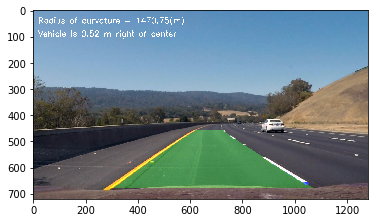

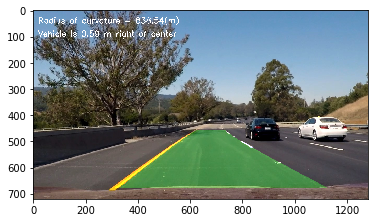

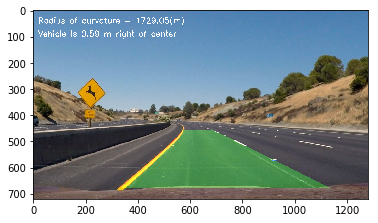

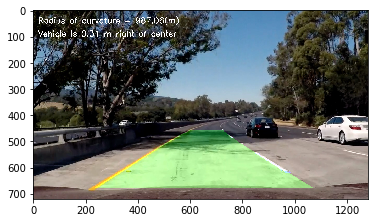

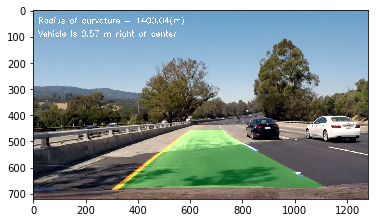

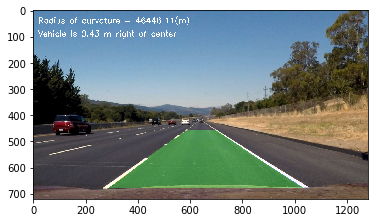

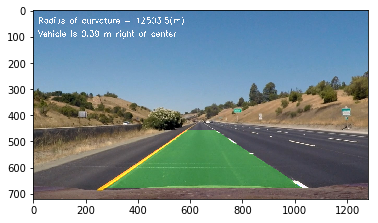

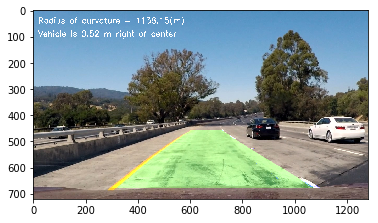

In [330]:
# read in test_images
testImages = glob.glob('./test_images/*.jpg')

for fName in testImages:
    # reset global variables for each iteration
    leftLine = Line()
    rightLine = Line()
    
    img = mpimg.imread(fName)
    result = pipeline(img)
    plt.imshow(result)
    plt.show()


In [323]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [331]:
# global variables
leftLine = Line()
rightLine = Line()

output = 'project_video_result.mp4'
clip1 = VideoFileClip('project_video.mp4')#.subclip(0,5)
white_clip = clip1.fl_image(pipeline)
%time white_clip.write_videofile(output, audio=False)

[MoviePy] >>>> Building video project_video_result.mp4
[MoviePy] Writing video project_video_result.mp4



 24%|██▍       | 303/1261 [01:00<03:10,  5.03it/s]


 48%|████▊     | 605/1261 [02:08<02:18,  4.73it/s]


 72%|███████▏  | 907/1261 [03:21<01:30,  3.89it/s]


 96%|█████████▌| 1205/1261 [04:36<00:13,  4.17it/s]


100%|█████████▉| 1260/1261 [04:50<00:00,  3.80it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_result.mp4 

CPU times: user 28min 9s, sys: 24.5 s, total: 28min 34s
Wall time: 4min 51s


In [332]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(output))